# Deep Feed Forward Artificial Neural Network
### With Neuron State Visualization

The point of this project was to understand _multilayer ANNs_ by building one from scratch.
The network uses sigmoid as activation function and is capable of visualizing what each neuron is "looking for" when applied to 2D clasification problems.

In [132]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from pprint import pprint
from copy import copy
%matplotlib inline

In [133]:
class NeuralNetwork(object):
    def __init__(self, inputs, layers, learning_rate, verbose=False):
        #parameters
        self.inputSize = inputs
        self.layersNum = len(layers)
        self.layerSizes = np.array(layers)
        self.learning_rate = learning_rate
        #weights
        extended = np.hstack(([inputs], layers)).ravel()
        self.weights = [np.random.randn(extended[i], extended[i+1]) for i in range(len(extended)-1)]
        #layers
        self.layers = [np.zeros(i, dtype="float64") for i in layers]
        #debugging
        self.verbose = verbose
        
    def forward(self, X):
        self.layers[0] = self.sigmoid(np.dot(X, self.weights[0]))
        for i in range(1, self.layersNum):
            self.layers[i] = self.sigmoid(np.dot(self.layers[i - 1], self.weights[i]))
        return self.layers[-1]

    def sigmoid(self, s):
        # activation function 
        return 1 / (1 + np.exp(-s))

    def sigmoidPrime(self, s):
        #derivative of sigmoid
        return s * (1 - s)

    def backward(self, X, y, o):
        # backward propagate through the network
        if self.verbose:
            print("Y")
            pprint(y)
            print("o")
            pprint(o)
        
        deltas = copy(self.layers)
        
        error = y - o # error in output
        deltas[-1] = error * self.sigmoidPrime(o) # applying derivative of sigmoid to error

        if self.verbose:
            print("output error")
            pprint(error)
            
            print("o_delta")
            pprint(deltas[-1])
            
            print("LAYERS")
            pprint(self.layers)

            print("WEIGHTS")
            for w in self.weights: pprint(w)

        for i in range(self.layersNum - 2, -1, -1):
            if self.verbose: print("Updating deltas", i)
            error = np.dot(deltas[i+1], self.weights[i+1].T) # 1x4
            if self.verbose:
                print("Error", i)
                pprint(error)
            deltas[i] = error * self.sigmoidPrime(self.layers[i]) #1x4
        
        if self.verbose:
            print("Deltas:")
            pprint(deltas)

            print("WEIGHTS BEFORE")
            for w in self.weights: pprint(w)
        
        if self.verbose: 
            print("-----")
            print("Updating weights", 0)
            pprint(self.weights[0])
            print("deltas[0]")
            pprint(deltas[0])
            print("change")
            pprint(self.learning_rate * np.dot(X.T, deltas[0]))
        
        self.weights[0] += self.learning_rate * np.dot(X.T, deltas[0])
        
        if self.verbose:
            print("after")
            pprint(self.weights[0])
            print("-----")
        
        for i in range(1, self.layersNum):
            if self.verbose: 
                print("-----")
                print("Updating weights", i)
                pprint(self.weights[i])
                print("deltas[" + str(i) + "]")
                pprint(deltas[i])
                print("layers")
                pprint(self.layers)
                print("change")
                pprint(self.learning_rate * np.dot(self.layers[i-1].T, deltas[i]))
            self.weights[i] += self.learning_rate * np.dot(self.layers[i-1].T, deltas[i])
            if self.verbose:
                print("after")
                pprint(self.weights[i])
                print("-----")
        if self.verbose:
            print("WEIGHTS AFTER")
            for w in self.weights: pprint(w)
    
    def train (self, X, y):
        o = self.forward(X)
        self.backward(X, y, o)
        
    def batch_train(self, X, y, batch_size):
        da_range = range(0, np.shape(y)[0], np.shape(y)[0] // batch_size)
        batches = np.split(X, da_range)
        ys = np.split(y, da_range)
        for i in range(len(da_range)):
            self.train(batches[i], ys[i])
            
    def visualize(self, radius):
        xys = np.array([x for x in range(-radius*10, radius*10)])
        xys = np.array(np.meshgrid(xys, xys)).T.reshape(-1, 2)
        xysq = xys / 10
        xysq = prepare(xysq)
        outs = self.forward(xysq)
        image = outs.ravel().reshape(radius*20, radius*20).T

        fig, ax = plt.subplots(1,2)
        fig.set_size_inches(12,4)
        sns.heatmap(image, square=True, vmin=0, vmax=1, cmap="coolwarm", xticklabels=False, yticklabels=False, ax=ax[0]).invert_yaxis()
        ax[0].set_title("Network output")
        sns.heatmap(np.round(image), vmin=0, vmax=1, square=True, cmap="coolwarm", xticklabels=False, yticklabels=False, ax=ax[1]).invert_yaxis()
        ax[1].set_title("Discrete output")
        
    def visualize_points(self, X, projection):
        outs = self.forward(X)
        image = [np.where(row > 0.5)[0][0] for row in outs]
        fig = plt.figure()
        
        if projection=="2D": 
            ax = fig.add_subplot(111)
            plt.scatter(X[:,0], X[:,1], c=image)
        elif projection=="3D":
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(X[:,0], X[:,1], X[:,2], c=image)
        
    def inspect(self, radius):
        xys = np.array([x for x in range(-radius*10, radius*10)])
        xys = np.array(np.meshgrid(xys, xys)).T.reshape(-1, 2)
        xysq = xys / 10
        xysq = prepare(xysq)

        NN.forward(xysq)

        neurons = []

        for i in range(NN.layersNum - 1):
            neurons.append(len(NN.layers[i][0]))

        width = np.max(neurons)
        width = np.maximum(width, np.shape(xysq)[1])
        height = NN.layersNum    

        fig, ax = plt.subplots(height, width)
        fig.set_size_inches(width * 5, height * 4)

        # input vectors visualization
        for i in range(np.shape(xysq)[1]):
            data = xysq[:,i]
            data = data.reshape(radius*20, radius*20).T
            sns.heatmap(data, cmap="coolwarm", xticklabels=False, yticklabels=False, ax=ax[0, i]).invert_yaxis()
            ax[0,i].set_title("Input [" + str(i) +"]")
        for i in range(np.shape(xysq)[1], width): ax[0,i].axis("off")

        # hidden neurons visualization 
        for i in range(NN.layersNum - 1):
            for j in range(neurons[i]):
                neuron = NN.layers[i].T[j]
                image = neuron.reshape(radius*20, radius*20).T
                sns.heatmap(image, vmin=0, vmax=1, cmap="coolwarm", xticklabels=False, yticklabels=False, ax=ax[i+1,j]).invert_yaxis()
                ax[i+1,j].set_title("Neuron [" + str(i) +"][" + str(j) +"]")
            for j in range(neurons[i], width): ax[i+1,j].axis("off")

### XOR problem
The XOR function is well known for its non-linearity. Here you can see that a simple 3 neuron network can approximate XOR pretty well. 

Loss:  0.259862817269
Loss:  0.215653409757
Loss:  0.126498477175
Loss:  0.0427201074757
Loss:  0.0128834956423
Loss:  0.00719343791856
Loss:  0.00489634947385
Loss:  0.00367575355387
Loss:  0.0029257678614
Loss:  0.00242120603381
Loss:  0.00205997287349
Predictions
array([[ 0.04037077],
       [ 0.9584924 ],
       [ 0.94695578],
       [ 0.04553594]])


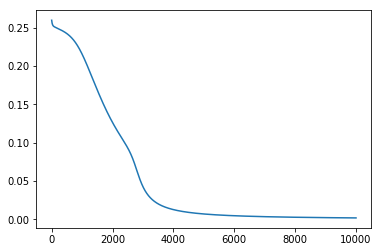

In [134]:
X = np.array([[0,0,1],[0,1,1],[1,0,1],[1,1,1]])
y = np.array([[0],[1],[1],[0]])

NN = NeuralNetwork(np.shape(X)[1], [3, 1], learning_rate=0.1, verbose=False)
losses = []
epochs = 10000
for epoch in range(epochs+1):
    #NN.batch_train(X, y, 10)
    NN.train(X,y)
    loss = np.mean(np.square(y - NN.forward(X)))
    if epoch%(epochs//10) == 0: print("Loss: ", loss)
    losses.append(loss)

plt.plot(losses)
print("Predictions")
pprint(NN.forward(X))

### 2D Classification
Let's define prepare() function which takes an array of (x, y) coordinates and expands it to an array which contains more features (like x * y, x ^ 2 etc.) and bias value. This will help introduce non-linearity to our network.

In [135]:
def prepare(X):
    return np.array([[x, y, x * y, 1] for x,y in X])/np.amax(X)

Now, let's create a simple dataset. We have points in 2D space, coordinates ranging from (-6, -6) to (6, 6), that are assigned either of two classes: blue or red.

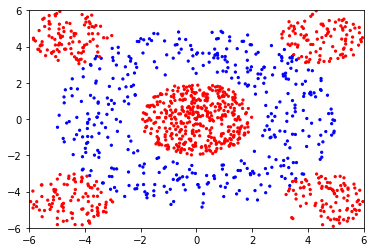

In [136]:
def add_circle(xs, ys, a, b, r, val, n, r2=0):
    i = 0
    ret = np.array([[a, b]])
    while(i < n - 1):
        (x,y) = np.random.rand(2) * 12 - 6
        if (x-a)**2 + (y-b)**2 <= r**2 and (x-a)**2 + (y-b)**2 >= r2**2:
            ret = np.append(ret, [[x, y]], axis=0)
            i += 1
    return np.append(xs, ret, axis=0), np.append(ys, np.array([[val] for x in range(n)]), axis=0)

# circle in a circle surrounded by circles
X = np.array([[0,0]])
y = np.array([[0]])
X, y = add_circle(X, y, 0, 0, 5, 0, 400, r2=2.5)
X, y = add_circle(X, y, 0, 0, 2, 1, 400)
X, y = add_circle(X, y, -4.5, -4.5, 1.5, 1, 100)
X, y = add_circle(X, y, -4.5, 4.5, 1.5, 1, 100)
X, y = add_circle(X, y, 4.5, -4.5, 1.5, 1, 100)
X, y = add_circle(X, y, 4.5, 4.5, 1.5, 1, 100)

xs = [x[0] for x in X]
ys = [x[1] for x in X]
colors = ["red" if x[0] == 1 else "blue" for x in y]
plt.scatter(xs, ys, s=5, c=colors)
plt.xlim(-6, 6)
plt.ylim(-6, 6)

trainX = prepare(X)
testX = prepare(X + np.random.randn(np.shape(X)[0], np.shape(X)[1])/10)

Alternatively, we may want an even simpler dataset. For each point: if both coordinates are positive, it's red, otherwise it's blue.

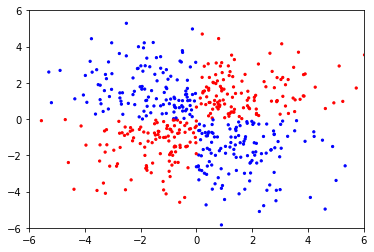

In [12]:
def condition(x,y):
    return x*y > 0

X = np.random.randn(500, 2)*2
y = np.array([[condition(a,b)] for a,b in X])

xs = [x[0] for x in X]
ys = [x[1] for x in X]
colors = ["red" if val == 1 else "blue" for val in y]
plt.scatter(xs, ys, s=5, c=colors)
plt.xlim(-6, 6)
plt.ylim(-6, 6)

X = prepare(X)

Now, let's initialize our network with two hidden layers, four neurons each, and one output layer.

In [137]:
NN = NeuralNetwork(trainX.shape[1], [4, 4, 1], learning_rate=0.03, verbose=False)

Evaluating next cell starts training, after it's complete, you will see a plot of loss function calculated on training and test datesets.
Reevaluating this cell trains the network further.

Train loss: 0.0100266029518 Test loss: 0.0102294027781
Train loss: 0.0098450792476 Test loss: 0.0100633555605
Train loss: 0.00968052762945 Test loss: 0.00991434668197
Train loss: 0.00953046100448 Test loss: 0.00978025654459
Train loss: 0.00939313836758 Test loss: 0.00965955130948
Train loss: 0.00926741465324 Test loss: 0.00955110264666
Train loss: 0.00915257828007 Test loss: 0.00945402999896
Train loss: 0.0090481837103 Test loss: 0.0093675722238
Train loss: 0.00895389982624 Test loss: 0.00929099777032
Train loss: 0.00886939515587 Test loss: 0.00922355637313
Train loss: 0.00879426951824 Test loss: 0.00916446605095


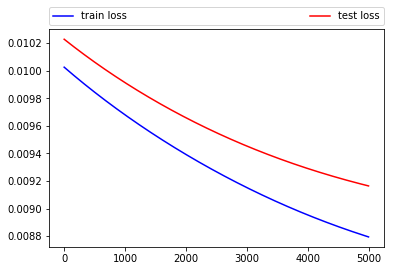

In [140]:
NN.learning_rate = 0.03
train_losses, test_losses = [], []
epochs = 5000
for epoch in range(epochs + 1):
    NN.batch_train(trainX, y, 10)
    #NN.train(X,y)
    train_loss = np.mean(np.square(y - NN.forward(trainX)))
    test_loss = np.mean(np.square(y - NN.forward(testX)))
    if epoch%(epochs//10) == 0:
        print("Train loss:", train_loss, "Test loss:", test_loss)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

plt.plot(train_losses, 'b-', label="train loss")
plt.plot(test_losses, 'r-', label="test loss")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

Now, let's visualize what our network thinks of this 2D space by feeding forward entire 12 x 12 area and plotting which class gets assigned to each point

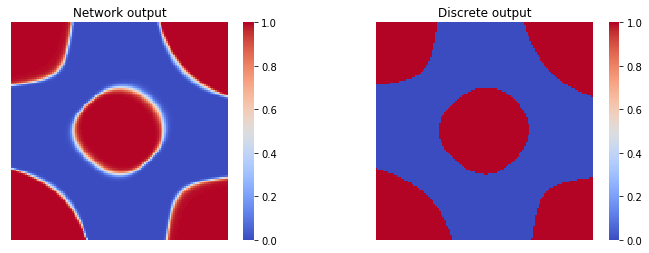

In [144]:
NN.visualize(radius=6)

Here's the _coolest_ part: we can feed our space to each neuron separetely and see how it modifies input. This is a way to visualize what "shapes" is each neuron looking for.

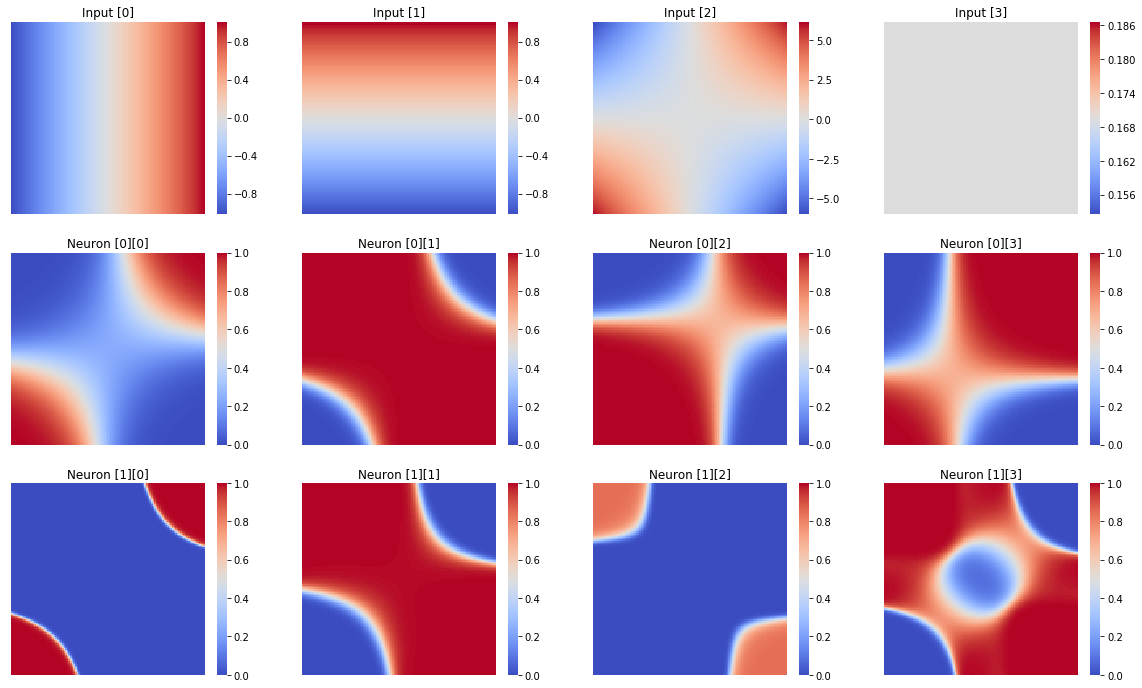

In [145]:
NN.inspect(radius=6)

### Iris flower data set

The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimetres. Based on the combination of these four features, we'll train our network to distinguish these species.

In [146]:
iris = sns.load_dataset("iris")
np.shape(iris)

(150, 5)

Here we assign classes using one-hot encoding, since there are three classes, out network's output's going to be a length 3 vector with the highest value indicating the species.

In [147]:
trainX = np.array(iris)[:,:-1]
trainY = np.array([[1,0,0]*50, [0,1,0]*50, [0,0,1]*50], dtype="float64").reshape(150,3)
trainX = trainX.astype("float64")

Let's train our model and see if it can learn to recognize each type of flower.

Loss:  0.246973628794
Loss:  0.0669647451208
Loss:  0.0146045356886
Loss:  0.0109032917806
Loss:  0.00809722252033
Loss:  0.00856643110545
Loss:  0.0198879311336
Loss:  0.00524868463214
Loss:  0.00462866655836
Loss:  0.00461023817327
Loss:  0.0045967992259


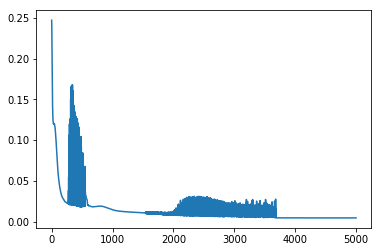

In [148]:
Flowey = NeuralNetwork(np.shape(trainX)[1], [10,10,10,3], learning_rate=0.03, verbose=False)
losses = []
epochs = 5000
for epoch in range(epochs + 1):
    Flowey.batch_train(trainX, trainY, 10)
    #Flowey.train(X,y)
    loss = np.mean(np.square(trainY - Flowey.forward(trainX)))
    if epoch%(epochs//10) == 0: print("Loss: ", loss)
    losses.append(loss)
plt.plot(losses)

Here we plot our data points in 2D and 3D space, using colour to denote each species.

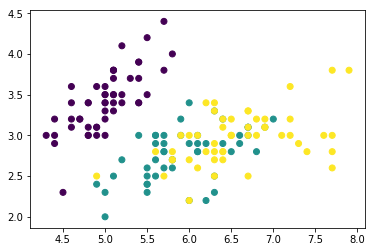

In [149]:
Flowey.visualize_points(trainX, projection="2D")

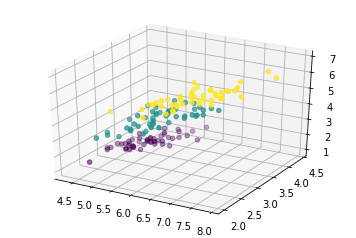

In [150]:
Flowey.visualize_points(trainX, projection="3D")

### MNIST dataset
The _Hello World_ of machine learning - a dataset containing lots of handwritten digits, each assigned a correct label.

In [152]:
from keras.datasets import mnist
(X_train_mnist, Y_train_mnist), (X_test_mnist, Y_test_mnist) = mnist.load_data()
print("X train shape:", X_train_mnist.shape)
print("Y train shape:", Y_train_mnist.shape)

X train shape: (60000, 28, 28)
Y train shape: (60000,)


5


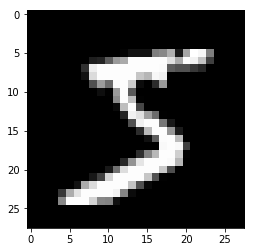

In [153]:
digit = X_train_mnist[0]
print(Y_train_mnist[0])
plt.imshow(digit, interpolation = "nearest", cmap = "gray")
plt.show()

In [154]:
X_train_mnist = X_train_mnist.reshape(60000, 28*28)
X_test_mnist = X_test_mnist.reshape(10000, 28*28)
Y_train_mnist = np.eye(10)[Y_train_mnist]
Y_test_mnist = np.eye(10)[Y_test_mnist]
print("X train shape:", X_train_mnist.shape)
print("Y train shape:", Y_train_mnist.shape)

X train shape: (60000, 784)
Y train shape: (60000, 10)


In [155]:
mnist_model = NeuralNetwork(784, [200,10], 0.003)

/Users/jakub/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp


Train loss: 0.101651100239 Test loss: 0.10177791799
Train loss: 0.0969531724365 Test loss: 0.0980246916509
Train loss: 0.0927485227192 Test loss: 0.0935784764972
Train loss: 0.0876014632683 Test loss: 0.0881344679584
Train loss: 0.0837416251694 Test loss: 0.0840191210544
Train loss: 0.0813494000554 Test loss: 0.0817898799805
Train loss: 0.0799968742336 Test loss: 0.0806864922826
Train loss: 0.0791352245301 Test loss: 0.0797146297619
Train loss: 0.0785559119537 Test loss: 0.0792495422442
Train loss: 0.0780641777062 Test loss: 0.0787993892896
Train loss: 0.0776261432197 Test loss: 0.0784496009132


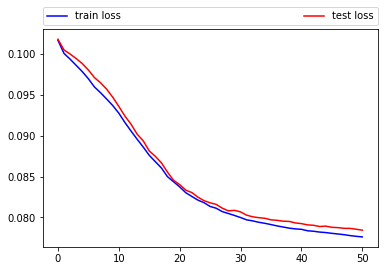

In [156]:
mnist_model.learning_rate = 0.001
train_losses, test_losses = [], []
epochs = 50
for epoch in range(epochs + 1):
    mnist_model.batch_train(X_train_mnist, Y_train_mnist, 50)
    #NN.train(X,y)
    train_loss = np.mean(np.square(Y_train_mnist - mnist_model.forward(X_train_mnist)))
    test_loss = np.mean(np.square(Y_test_mnist - mnist_model.forward(X_test_mnist)))
    if epoch%(epochs//10) == 0:
        print("Train loss:", train_loss, "Test loss:", test_loss)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

plt.plot(train_losses, 'b-', label="train loss")
plt.plot(test_losses, 'r-', label="test loss")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

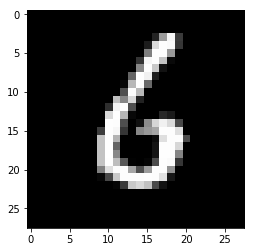

[[  4.63287461e-06   1.00711970e-07   1.92854555e-08   1.87484924e-06
    3.98343139e-08   1.62601473e-08   9.99960656e-01   1.70465790e-10
    1.07915143e-11   1.27330291e-08]]


/Users/jakub/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp


In [151]:
digit = X_test_mnist[50].reshape(28, 28)
plt.imshow(digit, interpolation = "nearest", cmap = "gray")
plt.show()
print(mnist_model.forward(digit.reshape(1, 28*28)))